In [1]:
### Includes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from math import pi
from IPython.display import HTML
from numpy import cos
from matplotlib import rc
from NS.compute import BIL

# Analytical covariance matrix computation

This notebook explain the use of the NS module to compute the analytical covariance matrix for DCT coefficients from a bloc (or 3) of photo-sites samples.

In [2]:
fig, ax = plt.subplots(figsize=(5, 5))

for m in range(1, 64+1):
    _k = (m-1)//8
    _l = (m-1)%8

    _M = np.fromfunction(lambda _i, _j: np.cos((pi/16)*_k*(2*_i+1))*np.cos((pi/16)*_l*(2*_j+1)), (8, 8), dtype=np.uint64)

    ax = plt.subplot(8, 8, m)
    ax = plt.imshow(_M, cmap = 'gray', clim = (-1, 1))
    ax = plt.axis('off')

plt.show()


In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Computation pipeline :

<ol>
<li>Photo-sites selection</li>
<li>Demosaicking</li>
<li>Selection</li>
<li>Permutation</li>
<li>DCT transform</li>
<li>Transposition</li>
</ol>

### 1. Photo-sites selection

The samples comes from $n_{b}\times n_{b}$ neighboring blocks, each composed of $8\times8$ photo-sites with the surrounding border included since interpolated values inside a $8\times8$ block need photo-site values surrounding this block (see Figure below). The result of flattening according to the columns this matrix is a contiguous flattened array which is therefore the the vector of the photo-sites samples denoted $\mathbf{y}\in\mathbb{N}^{(8n_{b}+2)^{2}}$.

##### $\mathbf{Y}\in\mathbb{N}^{(8n_{b}+2) \times (8n_{b}+2)}$

In [3]:
 s = 10

_fig, _ax = plt.subplots(figsize=(5, 5))

strs = ['R' if (i%2==0) else 'G' for i in range(s**2)]
for _m in range(1, s**2+1):
    _k = (_m-1)//s
    _l = (_m-1)%s
    
    _str = ''
    if(_k%2 == 0 and _l%2 == 1):
        _str = '$B$'
        _color = 'Blues'
    elif(_k%2 == _l%2):
        _str = '$G$'
        _color = 'Greens'
    else:
        _str = '$R$'
        _color = 'Reds'
    
    if(_k==0 or _l==0 or _k == 9 or _l == 9):
        _M = 0.15*np.ones((1, 1))
    else:
        _M = 0.5*np.ones((1, 1))

    _ax = plt.subplot(s, s, _m)
    _ax = plt.imshow(_M, cmap = _color, clim = (0, 1))
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    _ax = plt.text(0, 0, _str, fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    
#plt.tight_layout()
plt.show()

##### To $\mathbf{y}\in\mathbb{N}^{(8n_{b}+2)^{2}}$

In [4]:
s = 10

_fig, _ax = plt.subplots(figsize=(20, 1))

strs = ['R' if (i%2==0) else 'G' for i in range(s**2)]
idx = np.concatenate((range(1, 10), range(10, 20), range(90, 100+1)))

for _m, _idx in zip(idx, range(idx.shape[0])):
    _k = (_m-1)//s
    _l = (_m-1)%s
    
    _str = ''
    if(_k%2 == 0 and _l%2 == 1):
        _str = '$B$'
        _color = 'Blues'
    elif(_k%2 == _l%2):
        _str = '$G$'
        _color = 'Greens'
    else:
        _str = '$R$'
        _color = 'Reds'
    
    if(_k==0 or _l==0 or _k == 9 or _l == 9):
        _M = 0.15*np.ones((1, 1))
    else:
        _M = 0.5*np.ones((1, 1))

    if(_idx in range(14, 16)):
        _M = np.ones((1, 1))
        _str = '$...$'
        _color = 'gray'
        
    _ax = plt.subplot(1, 3*s, _idx+1)
    _ax = plt.imshow(_M, cmap = _color, clim = (0, 1))
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    _ax = plt.text(0, 0, _str, fontsize=10, ha='center', va='center', color='black', fontweight='bold')

### 2. Demosaicking and luminance averaging

In our case, this means that to perform color reconstruction and luminance averaging, we can define the demosaicking and averaging matrix $\mathbf{M_{L}}$ as:

$\mathbf{y_{L}}=\underbrace{(0.2126\cdot\mathbf{M_{R}}+0.7152\cdot\mathbf{M_{G}}+0.0722\cdot\mathbf{M_{B}})}_{\mathbf{M_{L}}}\cdot\mathbf{y}.$ 

With $\mathbf{y_{L}}\in\mathbb{R}^{(8n_{b}+2)^{2}}.$

In [5]:
 s = 10

_fig, _ax = plt.subplots(figsize=(5, 5))

strs = ['R' if (i%2==0) else 'G' for i in range(s**2)]
for _m in range(1, s**2+1):
    _k = (_m-1)//s
    _l = (_m-1)%s
    
    _str = ''
    if(_k%2 == 0 and _l%2 == 1):
        _str = '$Y$'
    elif(_k%2 == _l%2):
        _str = '$Y$'
    else:
        _str = '$Y$'
    
    if(_k==0 or _l==0 or _k == 9 or _l == 9):
        _M = 0.15*np.ones((1, 1))
    else:
        _M = 0.5*np.ones((1, 1))

    _ax = plt.subplot(s, s, _m)
    _ax = plt.imshow(_M, cmap = 'gray_r', clim = (0, 1))
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    _ax = plt.text(0, 0, _str, fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    
plt.show()

### 3. Selection

As stated above, the surrounding edges of $n_{b}\times n_{b}$ blocks of samples have been included in order to take into account the convolution window during demosaicking. Once the demosaicking operations have been carried out, they can now be discarded. Let's denote $\mathbf{L}$ the $(8n_{b}+2)\times(8n_{b}+2)$ photo-sites matrix with its outer border, and $\mathbf{L_{S}}$ without as depicted in Figure below. The matrix $\mathbf{M_{S}}\in\mathbb{R}^{(8n_{b})^{2}\times(8n_{b}+2)^{2}}$ can the be defined as :$\mathbf{y_{S}=\mathbf{\mathbf{M_{S}}}\cdot}\mathbf{y_{L}}\Leftrightarrow\mathrm{vec_{R}}(\mathbf{L_{S}})=\mathbf{\mathbf{M_{S}}}\cdot\mathrm{vec_{R}}(\mathbf{L})$With $\mathbf{y_{S}}\in\mathbb{R}^{(8n_{b})^{2}}$.

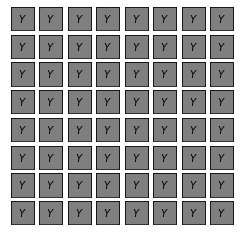

In [6]:
 s = 8

_fig, _ax = plt.subplots(figsize=(4, 4))

for _m in range(1, s**2+1):
    _k = (_m-1)//s
    _l = (_m-1)%s

    _str = '$Y$'
    _M = 0.5*np.ones((1, 1))
    
    _ax = plt.subplot(s, s, _m)
    _ax = plt.imshow(_M, cmap = 'gray_r', clim = (0, 1))
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    _ax = plt.text(0, 0, _str, fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    
plt.show()

### 4. Permutation

In [16]:
def perm_row(i):
    return (8*i)%(3*8)+(8*i)//(3*8)

s = 3

_fig, _ax = plt.subplots(figsize=(7, 7))

idxs = iter(np.arange((3*8)**2))

M = np.zeros((s*8, s*8))
for j in range(s*8):
    for i in range(s):
        M[j, i*8:(i+1)*8] = (s*j+i)*np.ones(8)
        
for _m in range(1, s**2-4):
    i, j = (_m-1)//s, (_m-1)%s
    _M = M[i*8:(i+1)*8, j*8:(j+1)*8]
    
    _ax = plt.subplot(s, s, _m)
    _ax = plt.imshow(_M, cmap = 'gray', clim = (0, 8*(s+1)))
    for k in range(8):
        _ax = plt.text(4-0.5, k+0.35, r'${}$'.format(str(k)), color = 'white', fontsize=10)
        
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    
plt.show()

In [17]:
s = 3

_fig, _ax = plt.subplots(figsize=(7, 7))

M = np.zeros((s*8, s*8))

for b in range(s**2):
    _B = np.zeros((8, 8))
    for l in range(8):
        _B[l, :] = (8*b+l)*np.ones(8)
    M[(b%3)*8:(b%3+1)*8, (b//3)*8:(b//3+1)*8] = _B
        

for _m in range(1, s**2-4):
    i, j = (_m-1)//s, (_m-1)%s
    _M = M[j*8:(j+1)*8, i*8:(i+1)*8]
    
    _ax = plt.subplot(s, s, _m)
    _ax = plt.imshow(_M, cmap = 'gray', clim = (0, 8*(s+1)))
    for k in range(8):
        _ax = plt.text(4-0.5, k+0.35, r'${}$'.format(k+(_m-1)*8), color = 'white', fontsize=10)
        
    _ax = plt.axis('on')
    _ax = plt.xticks([])
    _ax = plt.yticks([])
    
plt.show()

### 5. DCT transform

For a $8\times8$ block in the spatial domain, $\mathbf{X_{s}}$, its 2D-DCT block version written here as $\mathbf{X_{DCT}}$ can be expressed by the following matrix multiplication :

$$\mathbf{X_{DCT}}=\mathrm{DCT}(\mathbf{X_{S}})=\mathbf{A}\cdot\mathbf{X_{S}}\cdot\mathbf{A}^{t}=\mathbf{A}\cdot(\mathbf{A}\cdot\mathbf{X}_{\mathbf{S}}^{t})^{\boldsymbol{t}}$$

With :

$$\mathbf{A}=\left[\begin{array}{cccccccc}
a & a & a & a & a & a & a & a\\
b & d & e & g & -g & -e & -d & -b\\
c & f & -f & -c & -c & -f & f & c\\
d & -g & -b & -e & e & b & g & -d\\
a & -a & -a & a & a & -a & -a & a\\
e & -b & g & d & -d & -g & b & -e\\
f & -c & c & -f & -f & c & -c & f\\
g & -e & d & -b & b & -d & e & -g
\end{array}\right]$$,and : $$\left[\begin{array}{c}
a\\
b\\
c\\
d\\
e\\
f\\
g
\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}
\cos(\frac{\pi}{4})\\
\cos(\frac{\pi}{16})\\
\cos(\frac{\pi}{8})\\
\cos(\frac{3\pi}{16})\\
\cos(\frac{5\pi}{16})\\
\cos(\frac{3\pi}{8})\\
\cos(\frac{7\pi}{16})
\end{array}\right].$$
It should be observed that the multiplication by $\mathbf{A}$ and $\mathbf{A}^{t}$ is due to the fact that the DCT transform is separable and processes the columns and rows independently. In order to compute the covariance matrix of the spatial signal $\mathbf{X_{S}}$, we use vector notation by transforming the matrix $\mathbf{X_{S}}\in\mathbb{R}^{8\times8}$ into a vector $\mathbf{x_{S}}\in\mathbb{R}^{64}$ by concatenating the columns. As a result, the $8\times8$ matrix $\mathbf{A}$ is transformed into a $64\times64$ matrix $\mathbf{A_{v}}$ given by :$$\mathbf{A_{v}}=\left[\begin{array}{cccc}
\mathbf{A} & 0 & \ldots & 0\\
0 & \mathbf{A} & 0 & \vdots\\
\vdots & 0 & \ddots & 0\\
0 & \cdots & 0 & \mathbf{A}
\end{array}\right]=\sum\limits _{n=0}^{8-1}\oplus\mathbf{A}.$$

### 6. Transposition

We also define a transpose operator $\mathbf{T}\in\mathbb{R}^{64\times64}$ such as $\mathrm{vec_{c}}(\mathbf{X_{S}^{t}})=\mathbf{T}\cdot\mathrm{vec_{c}}(\mathbf{X_{S}})=\mathbf{T}\cdot\mathbf{x_{S}}$, with :

$$\mathbf{T}=\left[\begin{array}{ccccccccc}
1 & 0 & \ldots\\
0 & \ldots & \ldots & 1 & 0 & \ldots\\
 &  &  &  &  &  & 1 & 0 & \ldots\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 1 & \ldots\\
 &  &  & 0 & 1 & \ldots\\
 &  &  &  &  &  & 0 & 1 & \ldots\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{array}\right]\in\mathbb{R}^{64\times64}$$

## Result for an I.I.D signal

$$\begin{array}{cc}
\mathbf{\Sigma} & =\mathbb{E}\left[\mathbf{s_{T}}\cdot\mathbf{s_{T}}^{t}\right]=\mathbb{E}\left[(\mathbf{y_{T}}-\mathbf{x_{T}})\cdot(\mathbf{y_{T}}-\mathbf{x_{T}})^{t}\right],\\
 & =\mathbf{M}\cdot\mathbb{E}\left[\mathbf{s}\cdot\mathbf{s}^{t}\right]\cdot\mathbf{M^{t}}=\mathbf{M}\cdot\mathbb{E}\left[(\mathbf{y}-\mathbf{x})\cdot(\mathbf{y}-\mathbf{x})^{t}\right]\cdot\mathbf{M^{t}},
\end{array}$$

which for a RAW image defined by $\mu=\mathrm{cst}$ gives $\Sigma\propto\mathbf{M}\mathbf{M^{t}}$.

In [18]:
M = BIL.getPhotositesToDctMatrix(3, 'Y') #Luminance channel only

df = pd.DataFrame(np.dot(M, M.T))
cov = df
m = np.max(np.abs(np.array(cov)))/30

fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), dpi = 500)

ax = sns.heatmap(
    cov, 
    vmin=-m, vmax=m, center=0,
    cmap=sns.color_palette('RdBu_r', 50),
    square=True
)

ax.invert_yaxis()
x = np.linspace(0, 9*64-1, 9+1, dtype = np.int)
labels = np.linspace(0, 9*64-1, 9+1, dtype = np.int)
plt.xticks(x, labels)
plt.yticks(x, labels)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# X axis on top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# X axis on top
ax.yaxis.set_label_position('left')

ax.set_xlim(-0.5, cov.shape[0]+0.5)
ax.set_ylim(cov.shape[1]+0.5, -0.5)

plt.show()